<a href="https://colab.research.google.com/github/sandipanpaul21/ML-Clustering-in-Python/blob/master/13_Gaussian_Mixture_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Gaussian Mixture Model**

- Gaussian Mixture Models are **probabilistic models**
- It **use the soft clustering approach for distributing the points in different clusters**
- Gaussian Mixture Models (GMMs) assume that there are a certain number of Gaussian distributions and each of these distributions represent a cluster.
- Hence, a Gaussian Mixture Model tends to group the data points belonging to a single distribution together.

It uses an expectation–maximization approach which qualitatively does the following:

Choose starting guesses for the location and shape
Repeat until converged:
  1. **E-step:** for each point, find weights encoding the probability of membership in each cluster
  2. **M-step:** for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. 

**NOTE** - Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

In short, the expectation–maximization approach here consists of the following procedure:
  1. Guess some cluster centers
  2. Repeat until converged
    1. **E-Step:** assign points to the nearest cluster center
    2. **M-Step:** set the cluster centers to the mean

- Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
- The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers in K Means case, that maximization is accomplished by taking a simple mean of the data in each cluster.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import warnings
warnings.filterwarnings("ignore")

#### **Weaknesses of k-Means**

For example, if we have simple blobs of data, the K-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

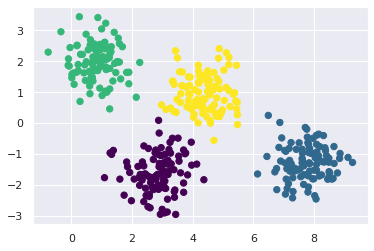

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

- From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others
- For example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.

- **Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments** (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

- One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.

- This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

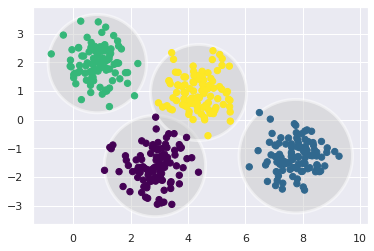

In [3]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))
  
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

- An important observation for k-means is that these cluster models **must be circular** : k-means has no built-in way of accounting for oblong or elliptical clusters.

- So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

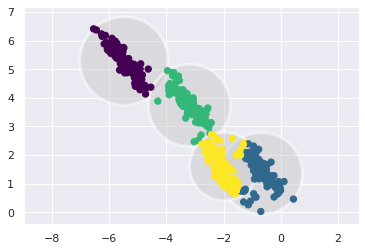

In [4]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

- By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
- This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
- One might imagine addressing this particular situation by preprocessing the data with PCA, but in practice there is no guarantee that such a global operation will circularize the individual data.

- **These two disadvantages of k-means**
  1. Its lack of flexibility in cluster shape
  2. Lack of probabilistic cluster assignment : mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

**Possible Solution Approach** 
1. You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
2. You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.

**It turns out these are two essential components of a different type of clustering model, Gaussian mixture models**

#### **Generalizing E–M: Gaussian Mixture Models**

 - A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.

- In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

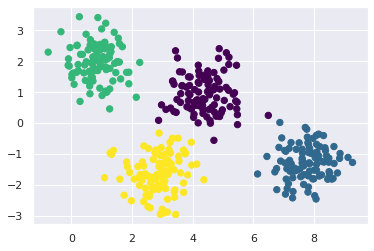

In [5]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

- But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments

- In Scikit-Learn this is done using the ``predict_proba`` method : This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [6]:
print('Top 5 rows,each row(datapoint) probability to belong to respective 4 Clusters')
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

Top 5 rows,each row(datapoint) probability to belong to respective 4 Clusters
[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


- We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction
- Looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment

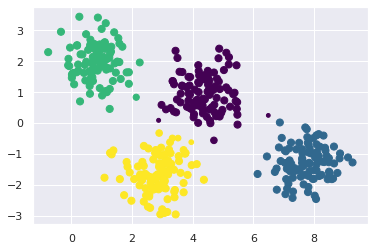

In [7]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

**Under the hood, a Gaussian mixture model is very similar to *k*-means:** it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape
2. Repeat until converged:
   1. **E-step**: for each point, find weights encoding the probability of membership in each cluster
   2. **M-step**: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

- The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
- Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

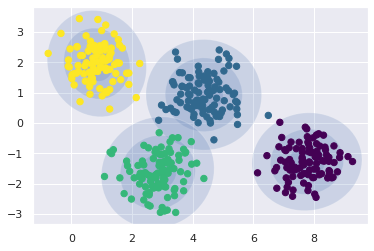

In [8]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

# With this in place, we can take a look at what the four-component GMM gives us for our initial data:
gmm = mixture.GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

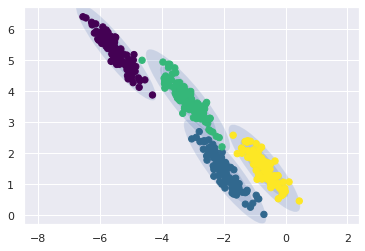

In [9]:
gmm = mixture.GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

#### **Choosing the covariance type**

- If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
- This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
- The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
- A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal.
- The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
- A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

![(Covariance Type)](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/05.12-covariance-type.png?raw=1)

#### **GMM as Density Estimation**

- Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation
- That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function

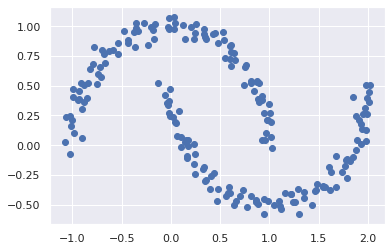

In [10]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

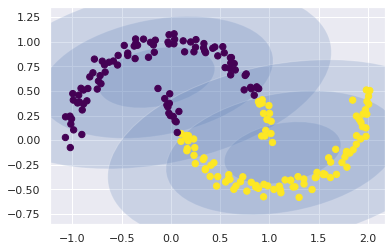

In [11]:
gmm2 = mixture.GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

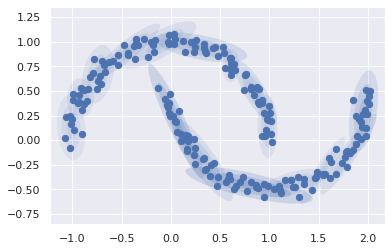

In [12]:
gmm16 = mixture.GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

#### **How many components?**

- The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset
- A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
- Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the Akaike information criterion (AIC) or the Bayesian information criterion (BIC)
- Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

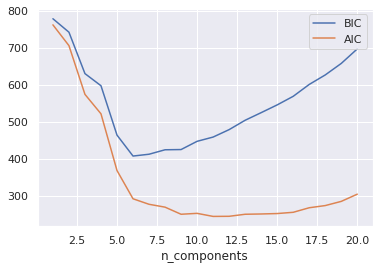

In [13]:
n_components = np.arange(1, 21)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

- The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use.
- The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.

As is typical with this sort of problem, the BIC recommends a simpler model.

**Notice the important point:** this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.

#### **Akaike Information Criterion**

The Akaike Information Criterion, or AIC for short, is a method for scoring and selecting a model.

The AIC statistic is defined for logistic regression as follows:

$AIC = -2/N * LL + 2 * k/N$

Where 
  1. N is the number of examples in the training dataset, 
  2. LL is the log-likelihood of the model on the training dataset
  3. k is the number of parameters in the model.

**The score, as defined above, is minimized, e.g. the model with the lowest AIC is selected.**

To use AIC for model selection, we simply choose the model giving smallest AIC over the set of models considered.

- Compared to the BIC method (below), the AIC statistic penalizes complex models less, meaning that it may put more emphasis on model performance on the training dataset, and, in turn, select more complex models.
- We see that the penalty for AIC is less than for BIC. This causes AIC to pick more complex models.


#### **Bayesian Information Criterion**

The Bayesian Information Criterion, or BIC for short, is a method for scoring and selecting a model.

The BIC statistic is calculated for logistic regression as follows :

$BIC = -2 * LL + log(N) * k$

Where 
  1. log() has the base-e called the natural logarithm
  2. LL is the log-likelihood of the model
  3. N is the number of examples in the training dataset
  4. k is the number of parameters in the model.

**The score as defined above is minimized, e.g. the model with the lowest BIC is selected**

The quantity calculated is different from AIC, although can be shown to be proportional to the AIC. 

- Unlike the AIC, the BIC penalizes the model more for its complexity, meaning that more complex models will have a worse (larger) score and will, in turn, be less likely to be selected.

**Note that,** compared to AIC, this penalizes model complexity more heavily.

Importantly, the derivation of BIC under the Bayesian probability framework means that if a selection of candidate models includes a true model for the dataset, then the probability that BIC will select the true model increases with the size of the training dataset. This cannot be said for the AIC score.

**NOTE :** A downside of BIC is that for smaller, less representative training datasets, it is more likely to choose models that are too simple.